In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import math
import scipy.optimize as opt
from scipy.optimize import fsolve
from scipy.optimize import minimize_scalar


In [2]:
sys.path.append('/groups/icecube/cyan/Utils')
from PlotUtils import setMplParam, getColour, getHistoParam 
from ExternalFunctions import nice_string_output, add_text_to_ax
setMplParam()

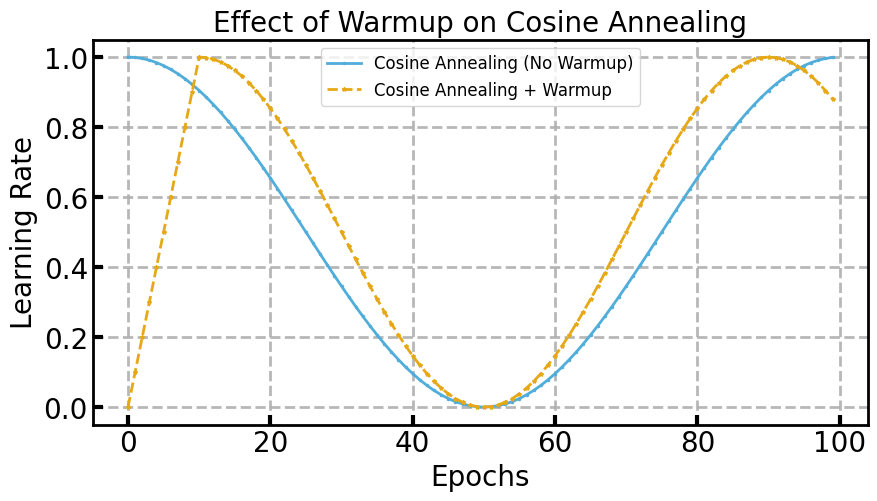

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math

def cosine_annealing_with_warmup(epochs, T_warmup, T_0, eta_max=1, eta_min=0):
    """
    Compute the learning rate schedule with cosine annealing and warmup.
    
    Parameters:
        epochs (int): Total epochs.
        T_warmup (int): Warmup duration.
        T_0 (int): Cosine cycle duration after warmup.
        eta_max (float): Maximum learning rate.
        eta_min (float): Minimum learning rate.
    
    Returns:
        (array, array): Epochs and corresponding learning rates.
    """
    lr_values = []

    for epoch in range(epochs):
        if epoch < T_warmup:
            # Linear Warmup Phase
            lr = eta_min + (epoch / T_warmup) * (eta_max - eta_min)
        else:
            # Cosine Decay Phase
            T_cur = epoch - T_warmup
            lr = eta_min + 0.5 * (eta_max - eta_min) * (1 + math.cos(math.pi * T_cur / (T_0 - T_warmup)))

        lr_values.append(lr)

    return np.arange(epochs), lr_values

def plot_cosine_annealing_with_warmup():
    # Plot different learning rate schedules
    epochs = 100
    T_warmup = 10  # Number of epochs for warmup
    T_0 = 50       # Total cycle length

    fig, ax = plt.subplots(figsize=(10, 5))

    # Without Warmup (Standard Cosine Annealing)
    x1, y1 = cosine_annealing_with_warmup(epochs, 0, T_0)
    ax.plot(x1, y1, label="Cosine Annealing (No Warmup)")

    # With Warmup
    x2, y2 = cosine_annealing_with_warmup(epochs, T_warmup, T_0)
    ax.plot(x2, y2, label="Cosine Annealing + Warmup", linestyle="dashed")

    ax.set_xlabel("Epochs")
    ax.set_ylabel("Learning Rate")
    ax.set_title("Effect of Warmup on Cosine Annealing")
    ax.legend()
    plt.show()
plot_cosine_annealing_with_warmup()

In [4]:
def compute_sawtooth_approx(n, x, a=1):
    total = np.zeros_like(x)
    bin_coeff_denominator = math.comb(2 * n, n)  # Binomial coefficient in denominator

    for k in range(1, n + 1):
        bin_coeff = math.comb(2 * n, n - k)  # Binomial coefficient in numerator
        term = (bin_coeff / (bin_coeff_denominator * k)) * np.sin(k * x / a)
        total += term

    return total

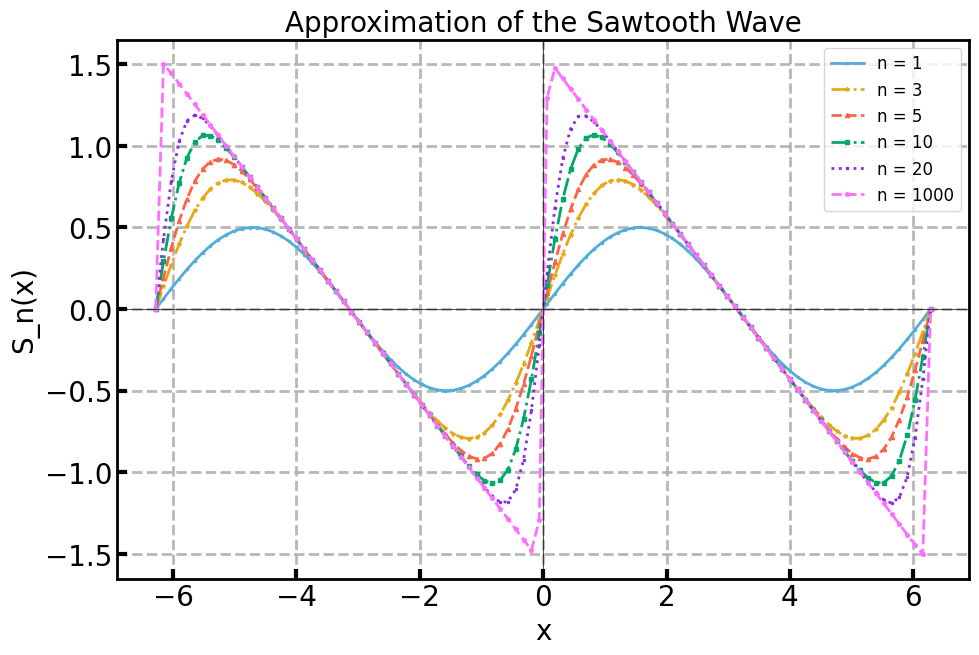

In [5]:
def plot_sawthooth_approx():
    # Plot the function for increasing values of n
    x = np.linspace(-2 * np.pi, 2 * np.pi, 100)
    n_values = [1, 3, 5, 10, 20,1000]

    fig, ax = plt.subplots(figsize=(11, 7))

    for n in n_values:
        y = compute_sawtooth_approx(n, x)
        ax.plot(x, y, label=f"n = {n}")

    ax.set_xlabel("x")
    ax.set_ylabel("S_n(x)")
    ax.set_title("Approximation of the Sawtooth Wave")
    ax.axhline(0, color='black', linewidth=0.5)
    ax.axvline(0, color='black', linewidth=0.5)
    ax.legend()
    plt.show()
plot_sawthooth_approx()

In [6]:
from enum import Enum
class LrDecayMode(Enum):
    LINEAR = 'linear'
    EXPONENTIAL = 'exponential'
    COSINE = 'cos'
    
    @staticmethod
    def from_str(value: str) -> 'LrDecayMode':
        """Get the corresponding LrDecay by string value."""
        for lr_decay in LrDecayMode:
            if lr_decay.value == value:
                return lr_decay
        return None
    
    @staticmethod
    def to_str(lr_decay: 'LrDecayMode') -> str:
        """Get the string value of the LrDecay."""
        return lr_decay.value

In [7]:
def asymmetric_sinusoidal_core(n, x, a, shift=0):
    total = np.zeros_like(x, dtype=np.float64)
    bin_coeff_denominator = math.comb(2 * n, n)

    for k in range(1, n + 1):
        bin_coeff = math.comb(2 * n, n - k)
        term = (bin_coeff / (bin_coeff_denominator * k)) * np.sin(a * k * (x + shift))
        total += term

    return total

def find_peak_x(n, a, shift=0):
    return minimize_scalar(lambda x: -asymmetric_sinusoidal_core(n, x, a, shift=shift), bounds=(0, 10), method='bounded').x

def asymmetric_sinusoidal_unit(n, x, a):
    first_peak_x = find_peak_x(n, a, shift=0)
    wavelength = find_peak_x(n, a, shift=first_peak_x)

    amplitude_norm = asymmetric_sinusoidal_core(n, first_peak_x, a, shift=0)
    return asymmetric_sinusoidal_core(n, x, wavelength*a, shift=first_peak_x) / amplitude_norm

def adapted_asymmetric_sinusoidal(n, x, a, amplitude, height):
    y = asymmetric_sinusoidal_unit(n, x, a)
    return height + y * amplitude

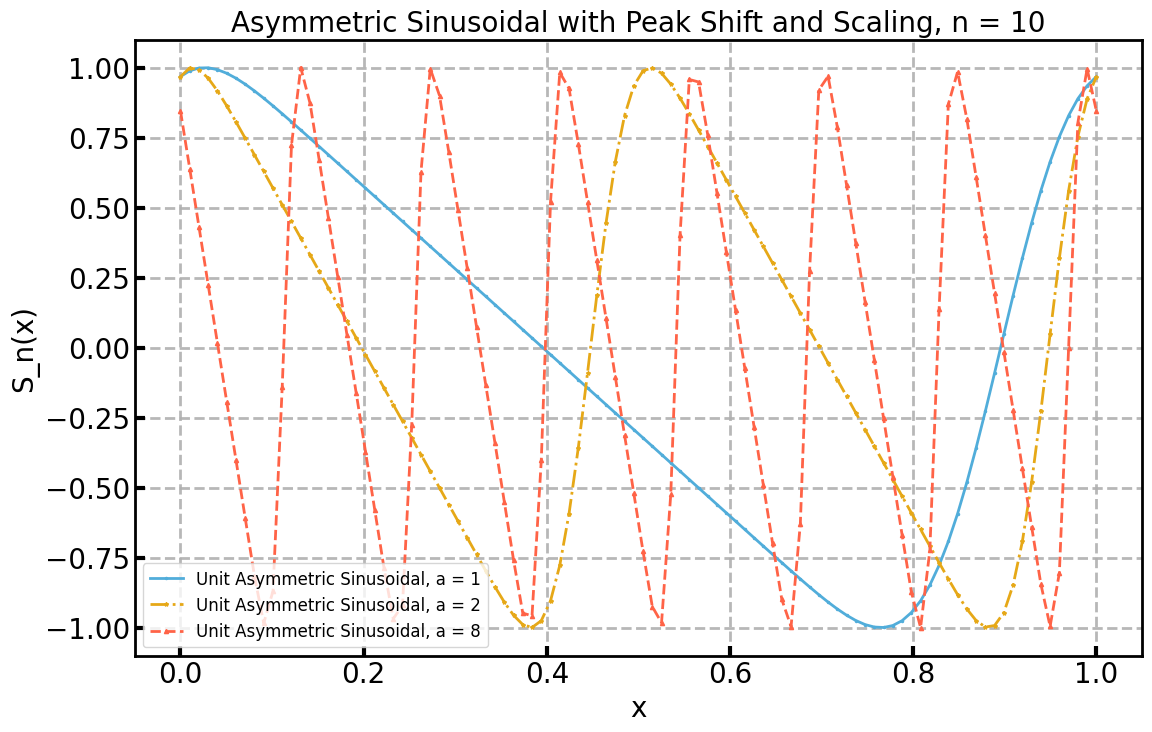

In [8]:
def plot_asymmetric_sinusoidal_unit():
    n = 10
    a_s = [1, 2, 8]
    x = np.linspace(0, 1, 100)
    
    fig, ax = plt.subplots(figsize=(13, 8))
    for a in a_s: 
        # y = asymmetric_sinusoidal_core(n, x, a)
        y_adj = asymmetric_sinusoidal_unit(n, x, a)
        ax.plot(x, y_adj, label=f"Unit Asymmetric Sinusoidal, a = {a}")
        # ax.plot(x, y, label="Asymmetric Sinusoidal")
    ax.set_xlabel("x")
    ax.set_ylabel("S_n(x)")
    ax.set_title(f"Asymmetric Sinusoidal with Peak Shift and Scaling, n = {n}")
    ax.legend()
plot_asymmetric_sinusoidal_unit()
    

In [9]:
def get_section_ceiling(section_index: int, lr_max, lr_min, n_sections, lr_decay_mode):
    log_lr_max = math.log(lr_max)
    log_lr_min = math.log(lr_min)
    
    if lr_decay_mode == LrDecayMode.LINEAR:
        ceiling = lr_max * ((min(n_sections/10, 0.9)) ** section_index)
    elif lr_decay_mode == LrDecayMode.EXPONENTIAL:
        log_ceiling = log_lr_max - (log_lr_max - log_lr_min) * (section_index / n_sections)
        ceiling = math.exp(log_ceiling)
    elif lr_decay_mode == LrDecayMode.COSINE:
        log_ceiling = log_lr_min + (log_lr_max - log_lr_min) * \
                    (1 + math.cos(math.pi * 0.25 * section_index / n_sections)) / 2
        ceiling = math.exp(log_ceiling)
    else:
        raise ValueError(f"Invalid lr_decay mode: {lr_decay_mode}")

    return ceiling

def get_section_floor(section_index: int, lr_max, lr_min, n_sections, lr_decay_mode):
    return get_section_ceiling(section_index + 1, lr_max, lr_min, n_sections, lr_decay_mode)

def get_section_and_x(step, section_length):
    section_index = step // section_length
    x = step % section_length
    return section_index, x

def get_section_amplitude_and_height(section_index:int, lr_max, lr_min, n_sections, lr_decay_mode):
    ceiling = get_section_ceiling(section_index, lr_max, lr_min, n_sections, lr_decay_mode)
    floor = get_section_floor(section_index, lr_max, lr_min, n_sections, lr_decay_mode)
    amplitude = (ceiling - floor) / 2
    height = ceiling - amplitude
    return amplitude, height

In [10]:
def compute_lr(step, lr_max, lr_min, n_sections, section_length, frequency_per_section, lr_decay_mode):
    section_index, x = divmod(step, section_length)
    section_index = min(section_index, n_sections - 1)

    amplitude, height = get_section_amplitude_and_height(section_index, lr_max, lr_min, n_sections, lr_decay_mode)

    x_scaled = (x / section_length) * frequency_per_section
    lr = adapted_asymmetric_sinusoidal(10, x_scaled, 1, amplitude, height)

    return lr

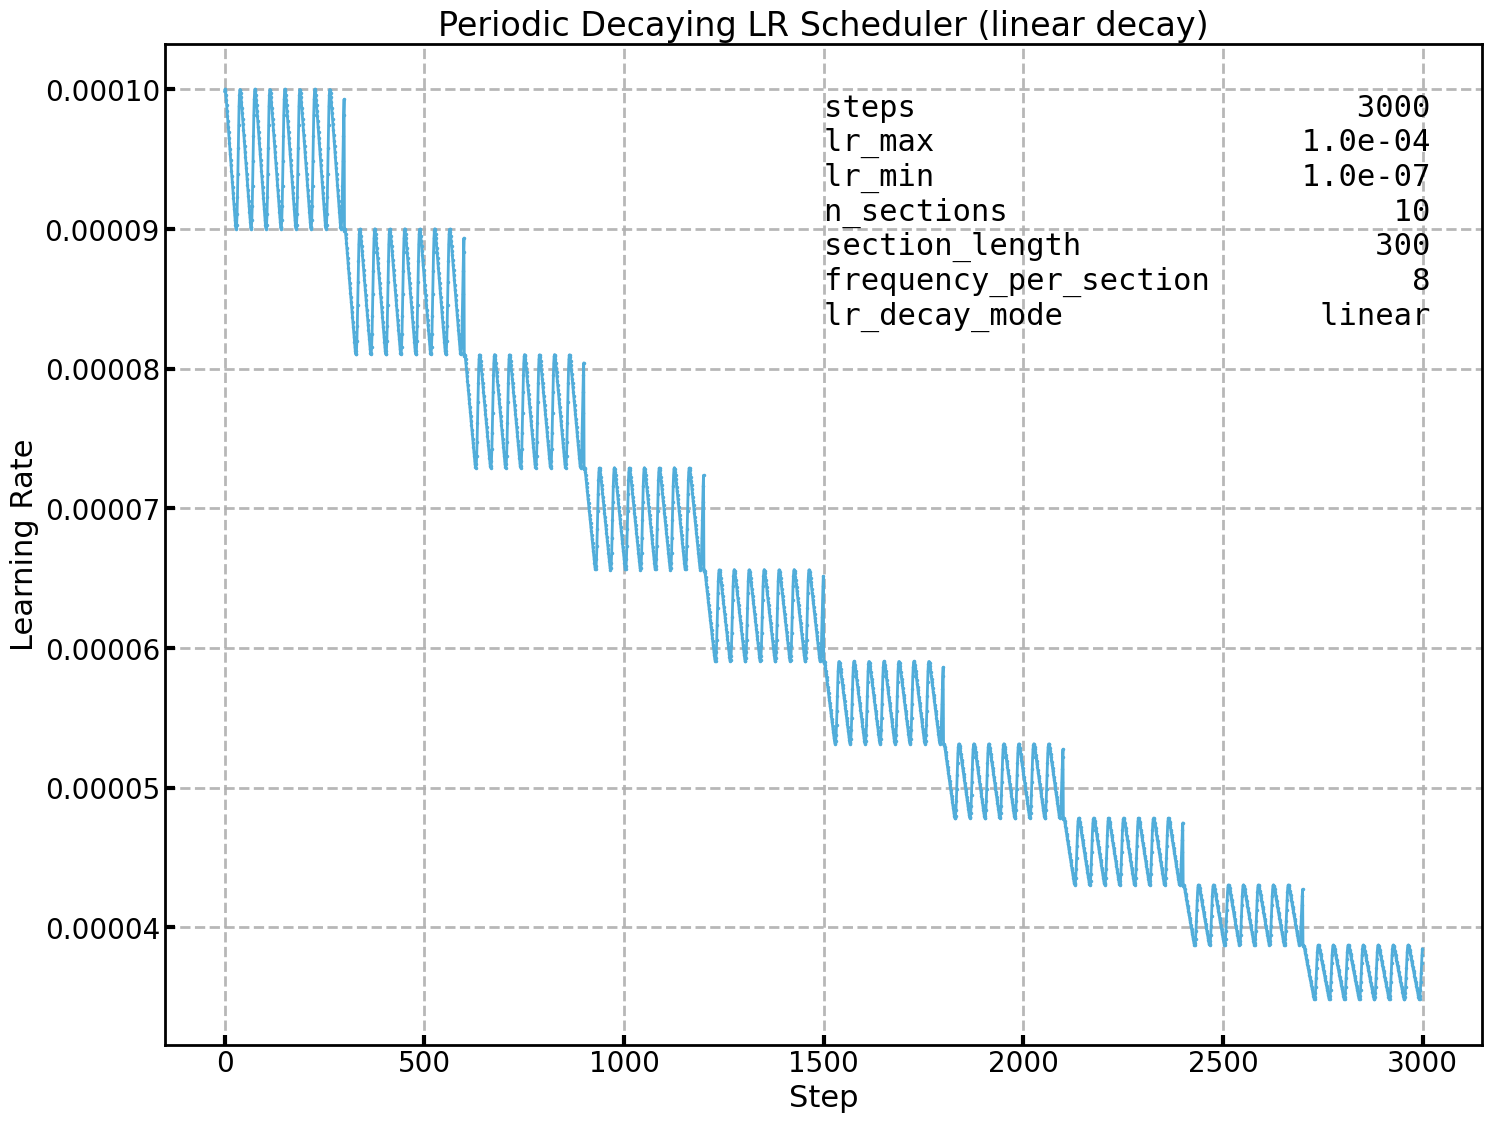

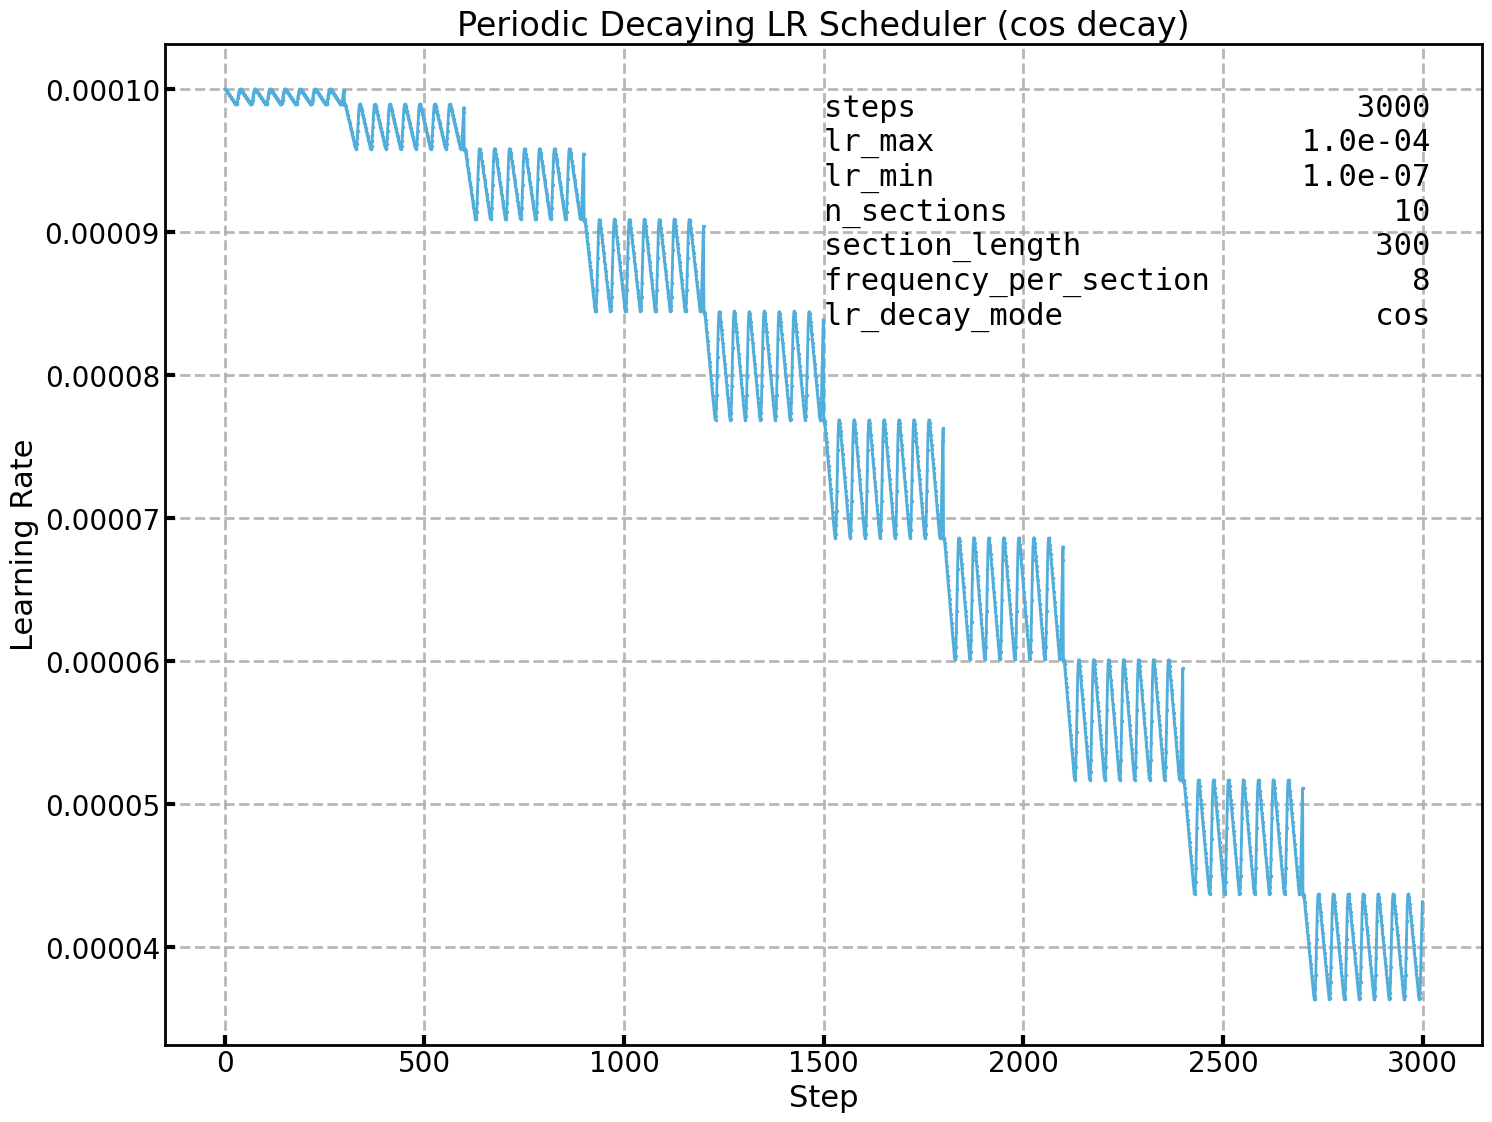

In [20]:
def plot_lr_schedule(lr_max, lr_min, n_sections, frequency_per_section, lr_decay_mode, total_steps = 3000):
    section_length = total_steps // n_sections
    lrs = [compute_lr(step, lr_max, lr_min, n_sections, section_length, frequency_per_section, lr_decay_mode) 
           for step in range(total_steps)]

    fig, ax = plt.subplots(figsize=(17, 13))
    ax.plot(lrs)
    ax.set_xlabel("Step", fontsize=22)
    ax.set_ylabel("Learning Rate", fontsize=22)
    ax.set_title(f"Periodic Decaying LR Scheduler ({lr_decay_mode.value} decay)", fontsize=24)
    # ax.set_yscale('log')
    d = {
        "steps": total_steps,
        "lr_max": f"{lr_max:.1e}",
        "lr_min": f"{lr_min:.1e}",
        "n_sections": n_sections,
        "section_length": f"{section_length}",
        "frequency_per_section": frequency_per_section,
        "lr_decay_mode": lr_decay_mode.value
    }
    add_text_to_ax(0.5, 0.95, nice_string_output(d), ax, fontsize=22, color='black')

    plt.show()
plot_lr_schedule(lr_max=1e-4, lr_min=1e-7, 
                 n_sections=10, 
                 frequency_per_section=8,
                 lr_decay_mode=LrDecayMode.LINEAR)
# plot_lr_schedule(lr_max=1e-4, lr_min=1e-7, 
#                  n_sections=10, 
#                  frequency_per_section=8,
#                  lr_decay_mode=LrDecayMode.EXPONENTIAL)
plot_lr_schedule(lr_max=1e-4, lr_min=1e-7, 
                 n_sections=10, 
                 frequency_per_section=8,
                 lr_decay_mode=LrDecayMode.COSINE)

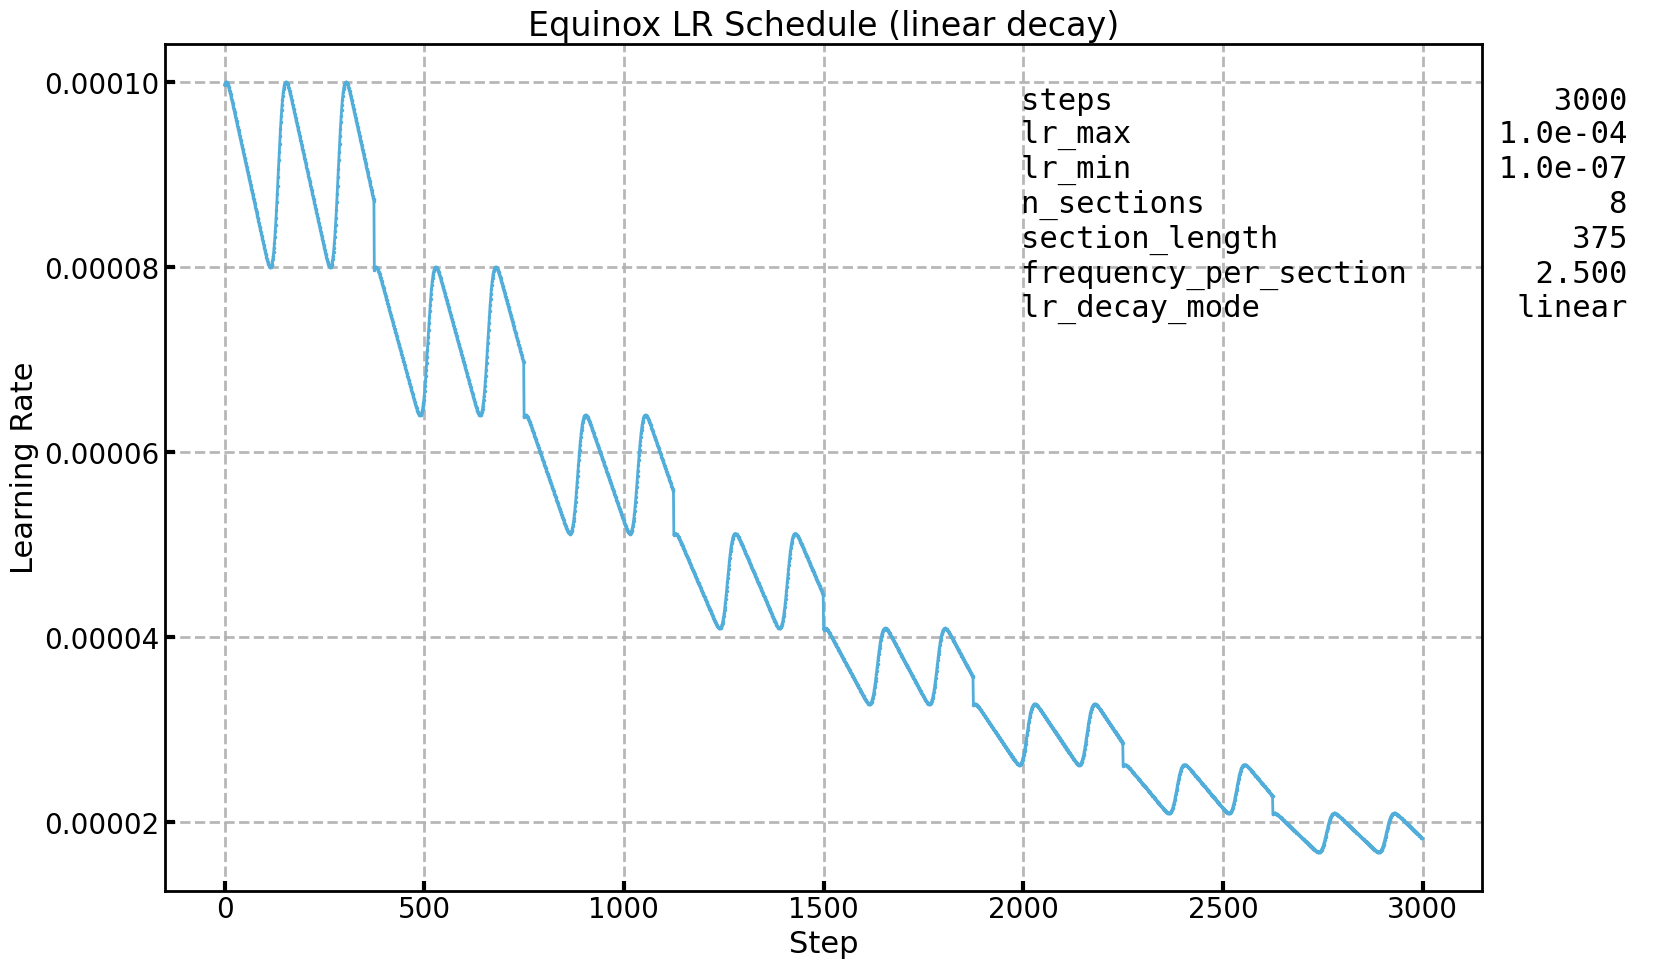

In [12]:
plot_lr_schedule(lr_max=1e-4, lr_min=1e-7, 
                 n_sections=8, 
                 frequency_per_section=2.5,
                 lr_decay_mode=LrDecayMode.LINEAR)

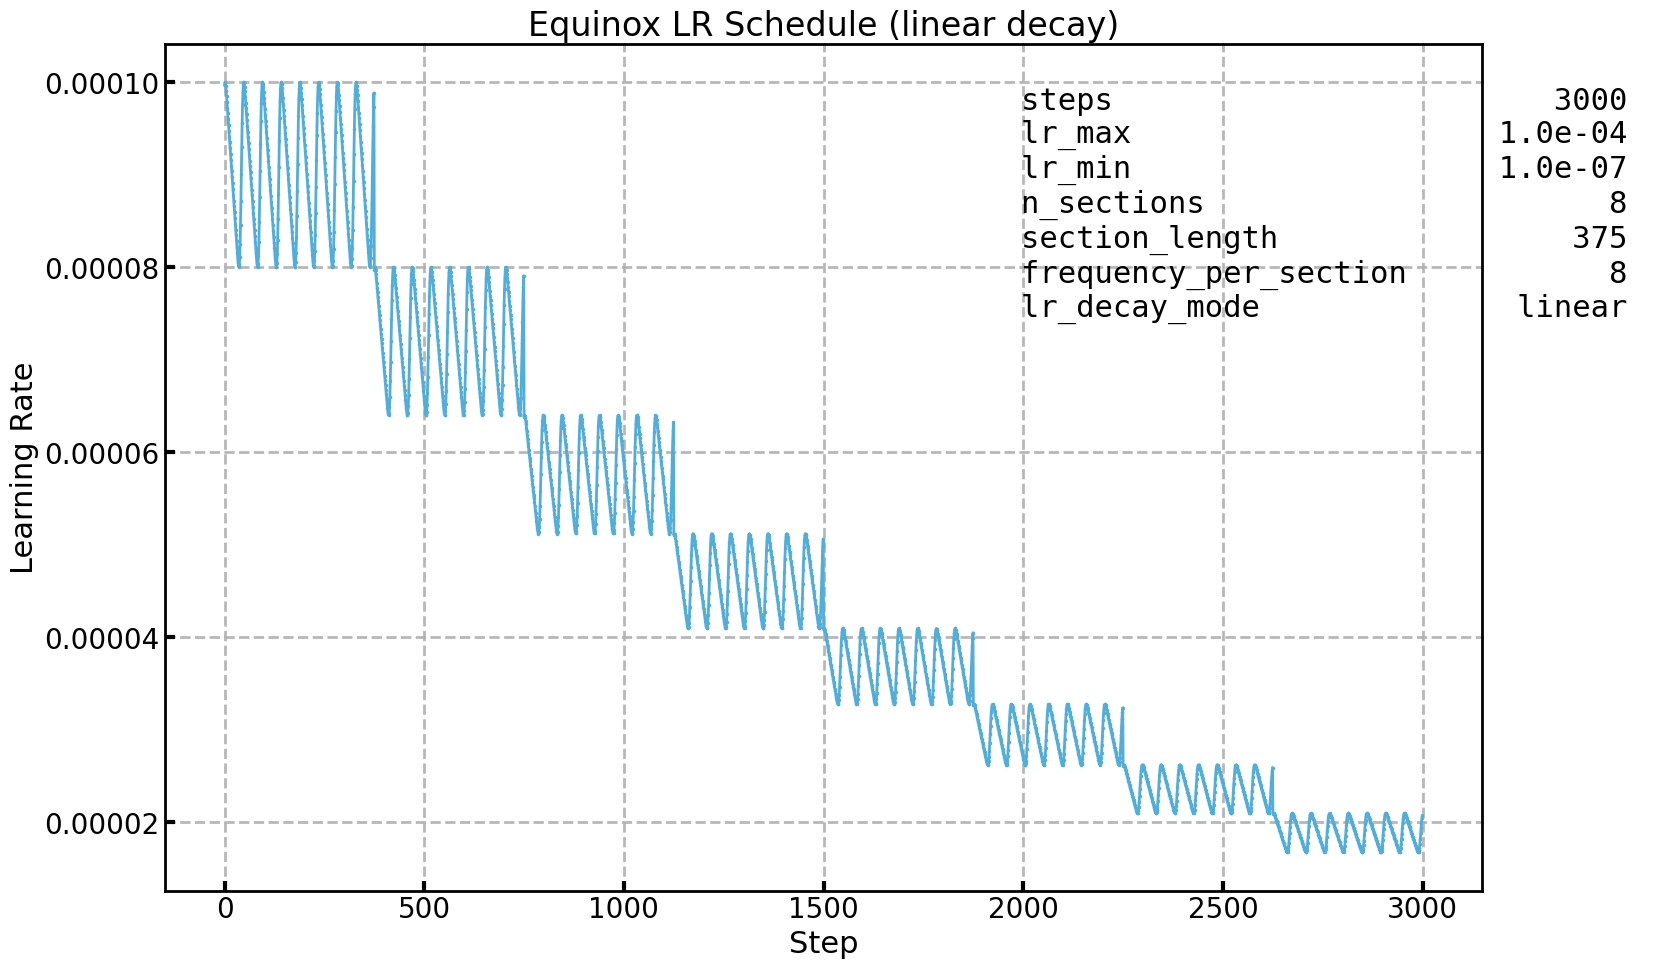

In [13]:
plot_lr_schedule(lr_max=1e-4, lr_min=1e-7, 
                 n_sections=8, 
                 frequency_per_section=8,
                 lr_decay_mode=LrDecayMode.LINEAR)

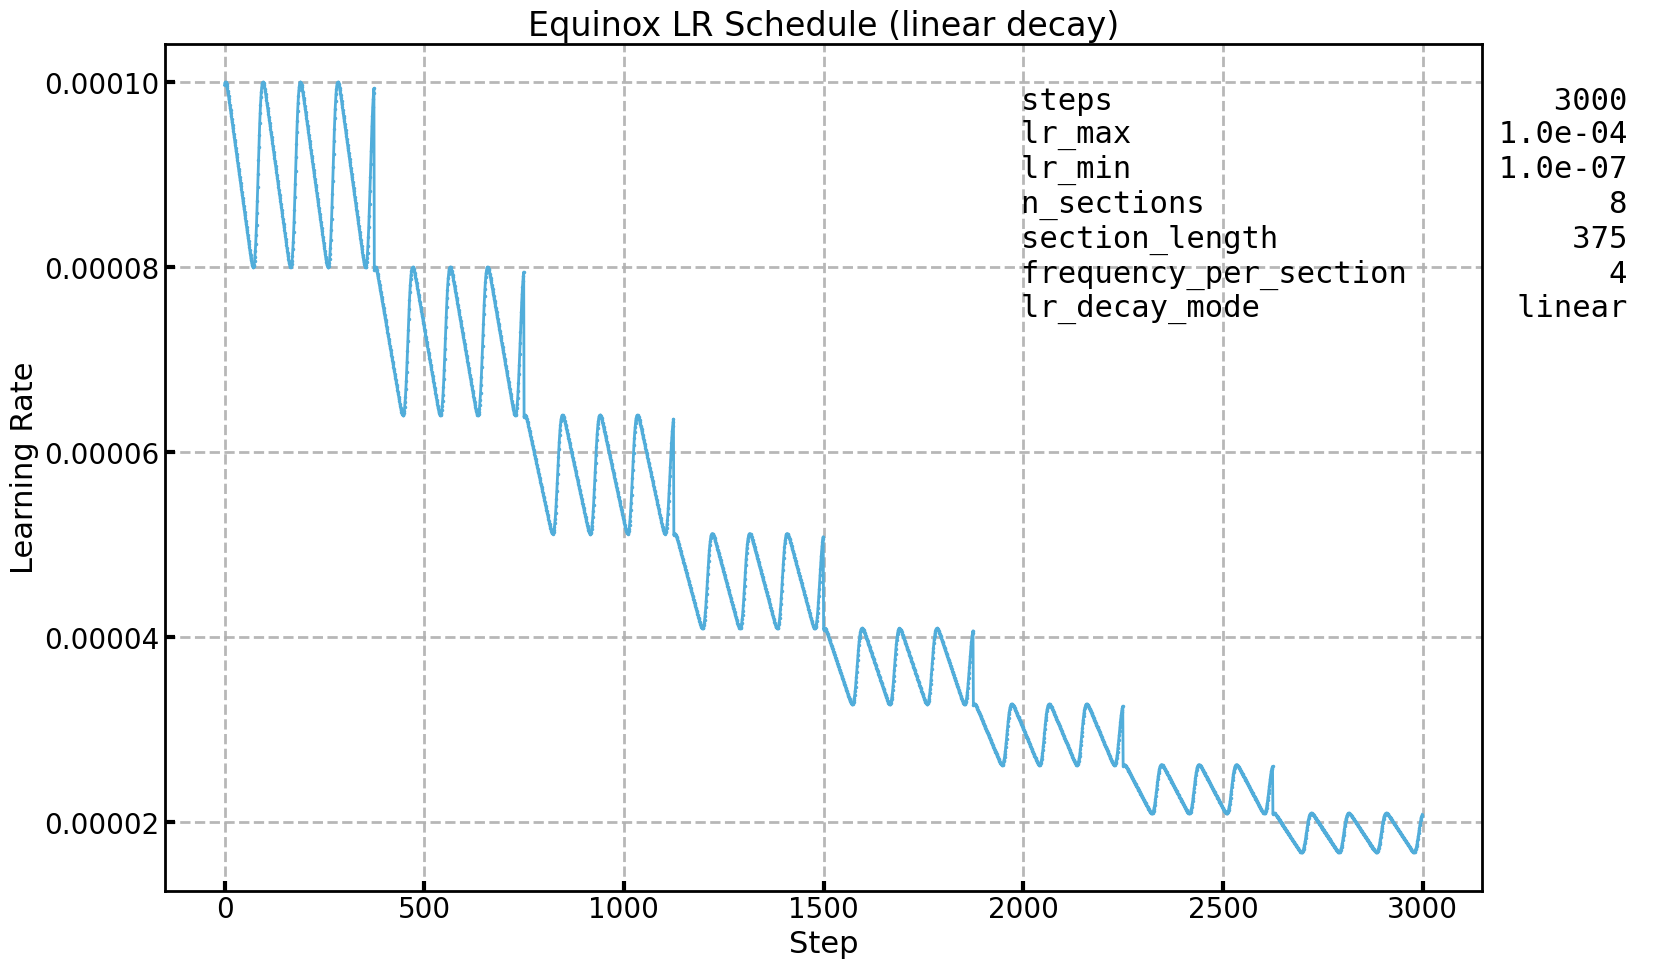

In [14]:
plot_lr_schedule(lr_max=1e-4, lr_min=1e-7, 
                 n_sections=8, 
                 frequency_per_section=4,
                 lr_decay_mode=LrDecayMode.LINEAR)

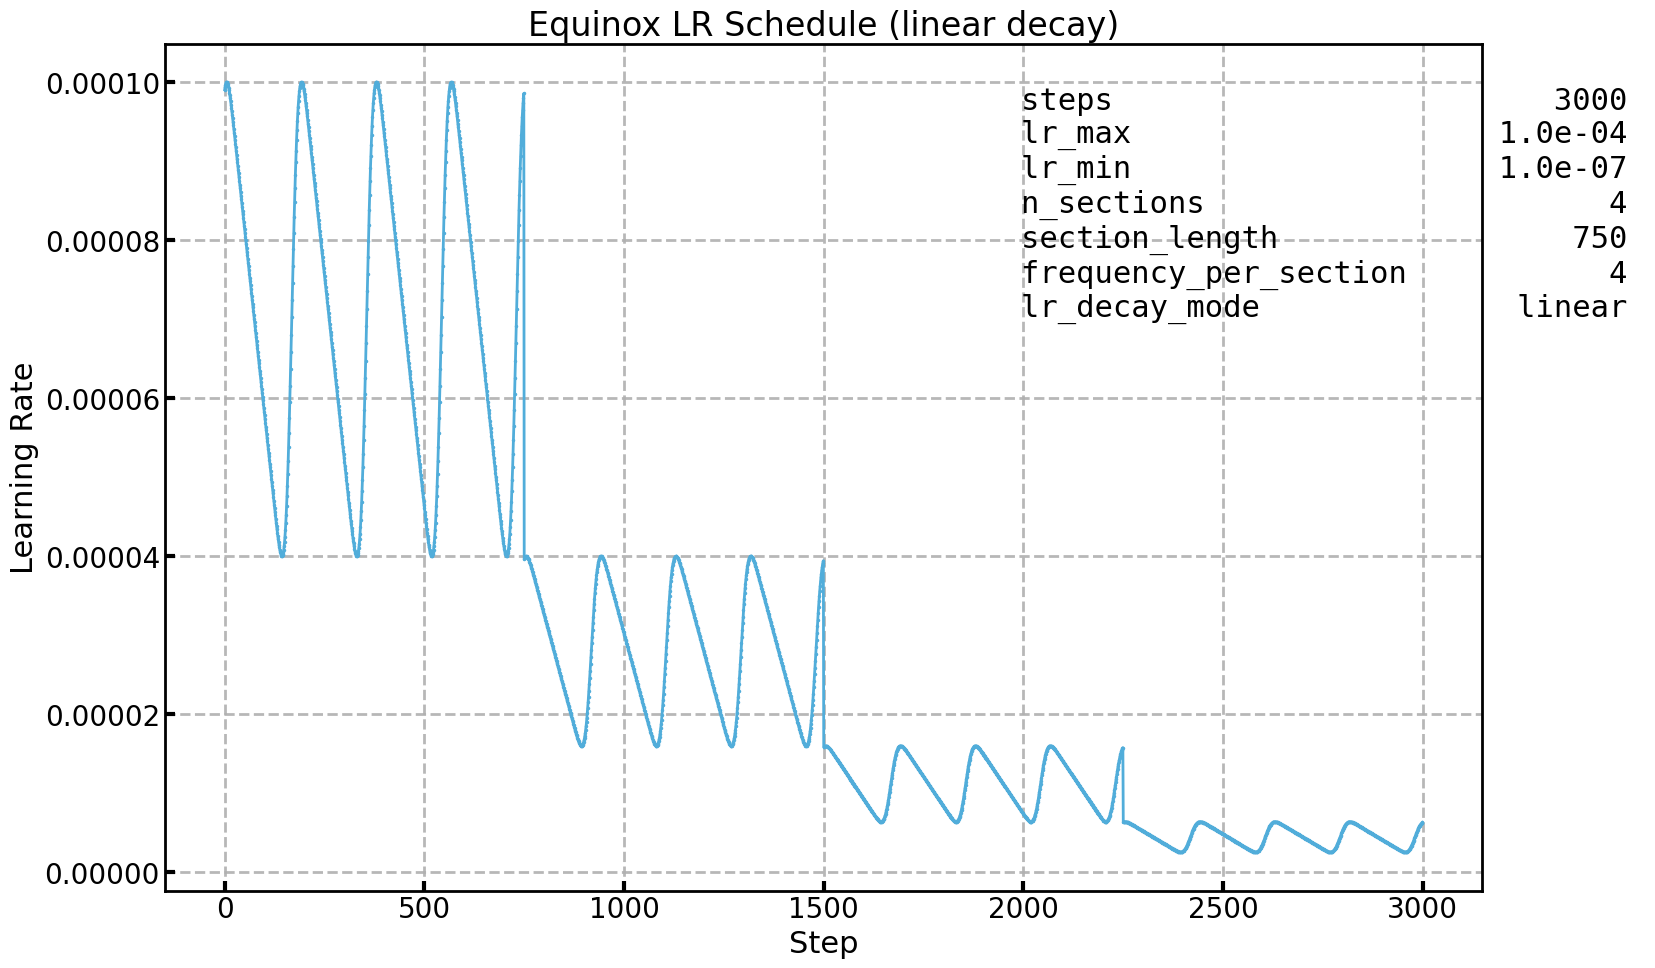

In [15]:
plot_lr_schedule(lr_max=1e-4, lr_min=1e-7, 
                 n_sections=4, 
                 frequency_per_section=4,
                 lr_decay_mode=LrDecayMode.LINEAR)

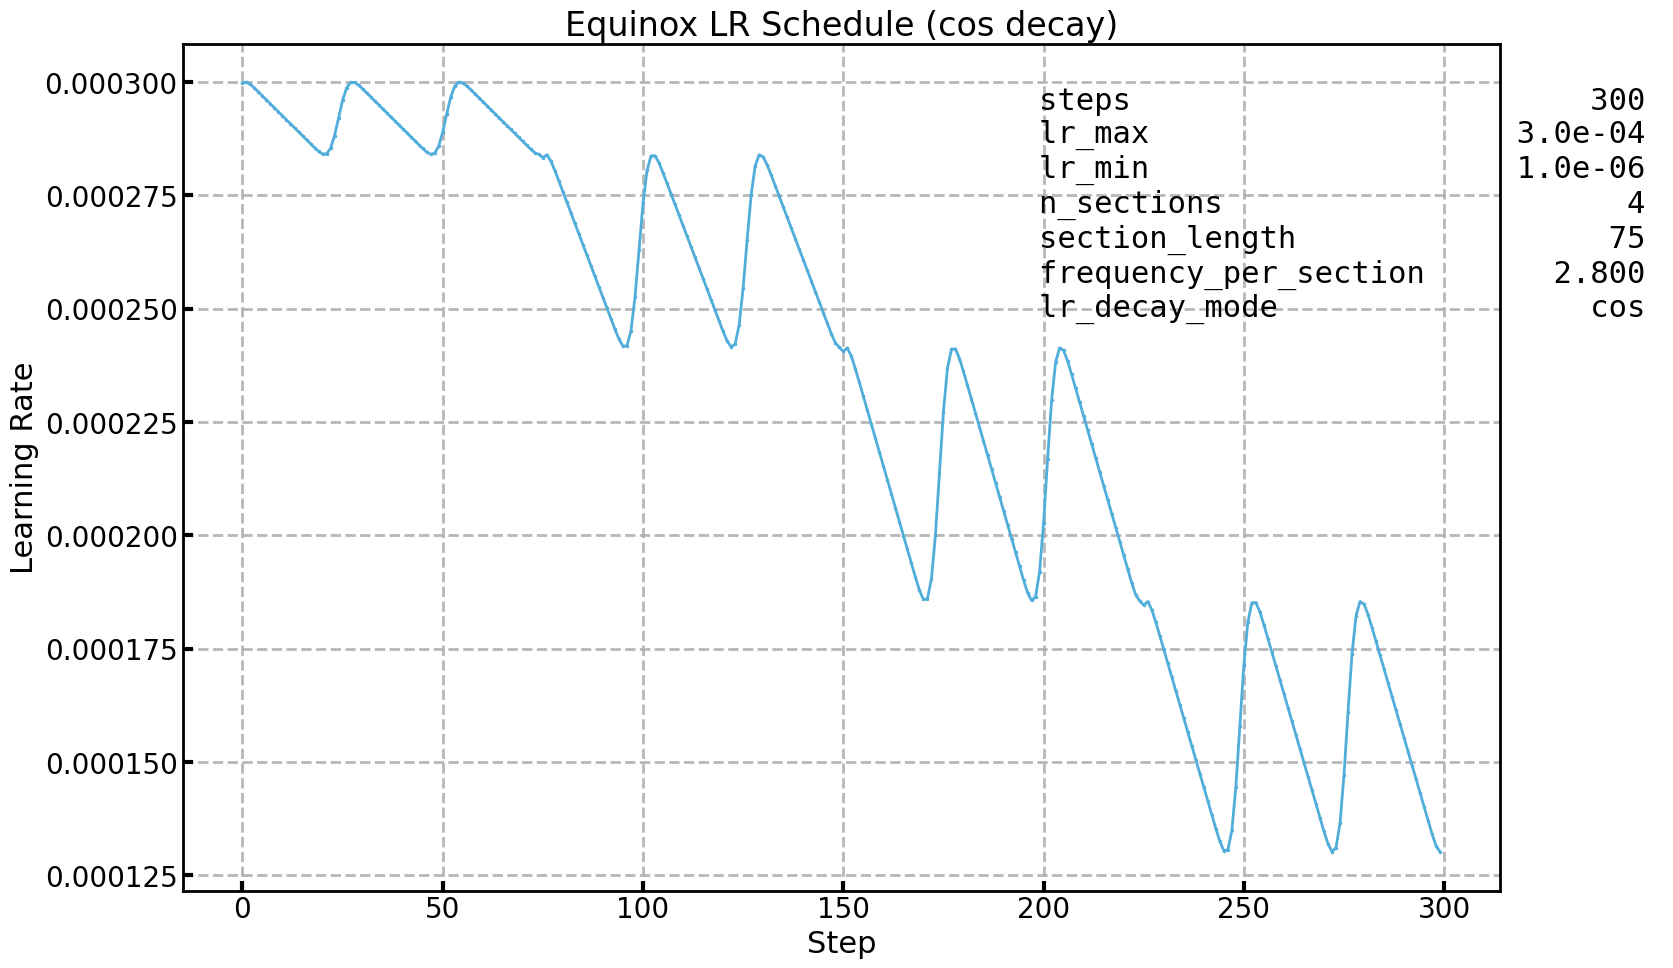

In [16]:
plot_lr_schedule(lr_max=3e-4, lr_min=1e-6, 
                 n_sections=4, 
                 frequency_per_section=2.8,
                 lr_decay_mode=LrDecayMode.COSINE,
                 total_steps=300)